In [179]:
import pandas as pd 
import numpy as np
import keras
import math 
import random 

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from lib.Trend import TrendData, extract_trend

In [180]:
def scale_col_values(
    df: pd.DataFrame, 
    col_name:str, 
    min_value:float=0, 
    max_value:float=1
): 
    values = df[col_name].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(min_value, max_value))
    scaled_values = scaler.fit_transform(values)
    df[col_name] = scaled_values.transpose()[0]
    return df

def squash_col_outliers(
    df: pd.DataFrame, 
    col_name: str, 
    min_quantile: float =0.01, 
    max_quantile:float =0.99
): 
    q_lo = df[col_name].quantile(min_quantile)
    q_hi  = df[col_name].quantile(max_quantile)
    
    df.loc[df[col_name] >= q_hi, col_name] = q_hi
    df.loc[df[col_name] <= q_lo, col_name] = q_lo
    return df

df = pd.read_csv("data/TSLA-d.csv", index_col=0)
df.pop("Volume")
df["Range"] = (df["High"] - df["Low"]) / df["Open"]
df.pop("Open")
df.pop("High")
df.pop("Low")
df['Change'] = df["Adj Close"].pct_change()
df = df. tail(-1) 
df.pop("Close")
df = pd.DataFrame(df.values, columns=['Adj Close', 'Range', 'Change'])
df = squash_col_outliers(df, 'Change')
df = squash_col_outliers(df, "Range", min_quantile=0.0, max_quantile=0.97)


df = scale_col_values(df, 'Change')
df = scale_col_values(df, 'Range')
df.head()

,Adj Close,Range,Change
0,1.588667,1.000000,0.437608
1,1.464000,1.000000,0.057881
2,1.280000,1.000000,0.000000
3,1.074000,1.000000,0.000000
4,1.053333,0.989125,0.353968


In [181]:
# V. Extracting the Trend

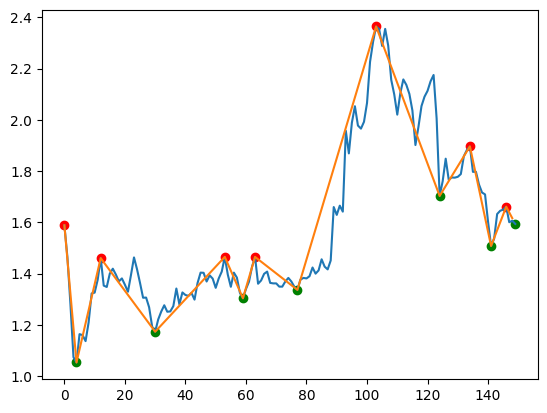

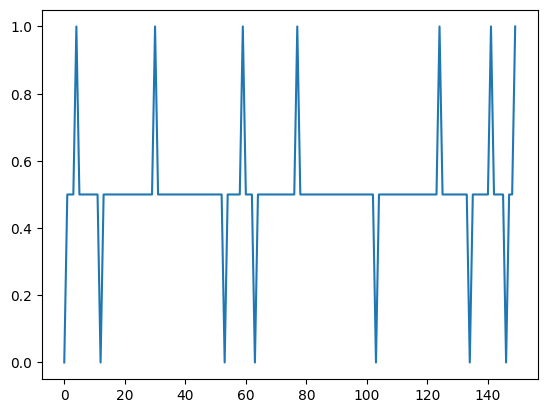

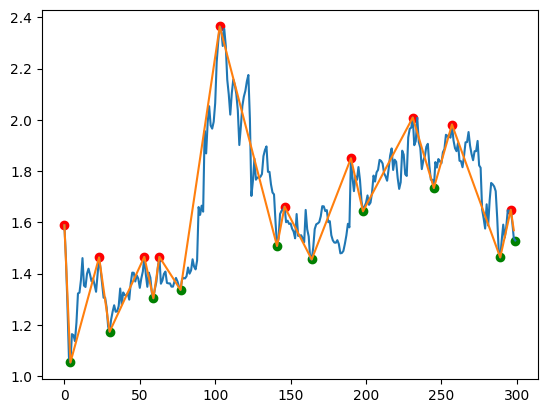

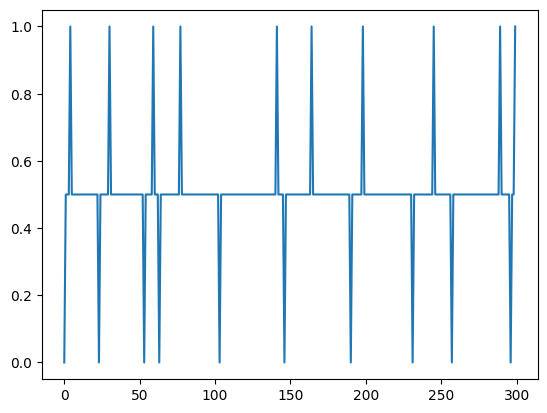

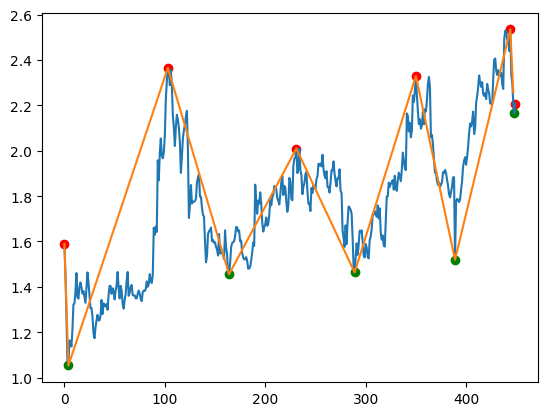

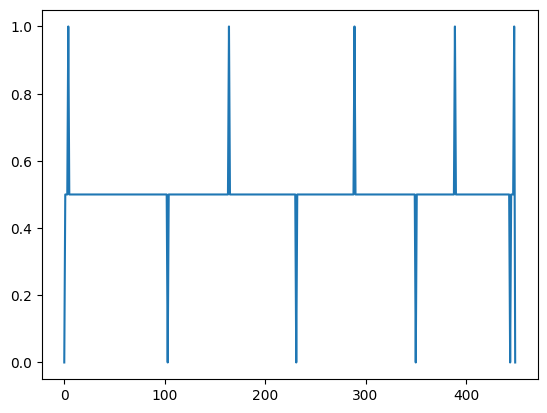

In [177]:
'''
Earlier in the process, we 'removed' the trend from the data by extracting the daily % change. The trend is 
of course still inherent in the % daily change, but it's no longer obvious. However, the trend can be an important 
feature of the data, and for some purposes one may want to extract it as well.  

There are many ways to extract the trend from a time series. One might use arithmetic decomposition, 
or one might be inclined to use a simple MA or EMA, 
but the problem (may be a problem, depending on what you're doing) is that moving averages tend to lag. 
To accurately capture the exact high and low points based on a certain given granularity, I created a 
function to discern non-seasonal (or quasi-seasonal) highs and lows, and draw trendlines between them. 
For this example, I'm going to create then, then extract from it a range of values where 
0: means the trend turns downwards at this point (it's a high point) 
1: means the trend turns upwards at this point (it's a low point)
0.5: means that the current trend continues 

This technique may not be good for de-noisifying a series, but it's good for extracting the pivot points. 
Below is a demonstration of it, with the trendlines overlaid on the original price series, over a few small 
segments of the series (the small segments are more convenient to view). 

Note that passing a smaller value for the period parameter will capture more of the price spikes, and passing
a larger value will tend to capture fewer of them. 
'''
step_size = 150
range_size = 10

for i in range(3): 
    # extract trend from a subset of the price series 
    series = df['Adj Close'][:i*step_size+step_size]
    trend = extract_trend(series, range_size)
    
    # scatterplot: highs are red, lows are green 
    highs_x, highs_y = trend.as_scatterplot('hi')
    lows_x, lows_y = trend.as_scatterplot('lo')

    plt.scatter(highs_x, highs_y, color='red')
    plt.scatter(lows_x, lows_y, color='green')
    plt.plot(series)
    
    # overlay trend lines 
    plt.plot(trend.as_price_series(series[0]))
    plt.show()
    
    # show boolean 
    plt.plot(trend.as_boolean(series[0]))
    plt.show()
    range_size *= 2

In [178]:
'''
Then this data will be added as a new column to the DataFrame, called 'Trend'. Note that the data is already 
normalized between 0 and 1, so it doesn't require scaling. And there's no need to handle outliers, because 
there are none. 
'''
trend = extract_trend(df['Adj Close'], 100)
df['Trend'] = trend.as_boolean(df['Adj Close'][0])
print(len(trend.as_boolean(df['Adj Close'][0])))
df.head()

ValueError: Length of values (3210) does not match length of index (3211)

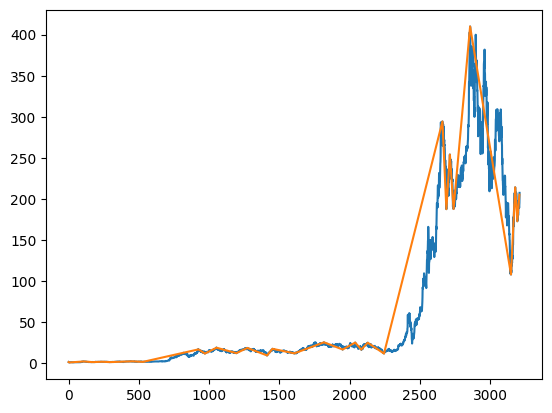